In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

In [86]:
# Создаём обучающую выборку
ames_data = pd.read_csv('./data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
X = ames_data[['Lot Frontage', 'Lot Area']]
y = ames_data['SalePrice']

In [87]:
# Инициализируем модель дерева решений с максимальной глубиной 3 и обучаем её
dt_reg = tree.DecisionTreeRegressor(max_depth=3)
dt_reg.fit(X.values, y)

DecisionTreeRegressor(max_depth=3)

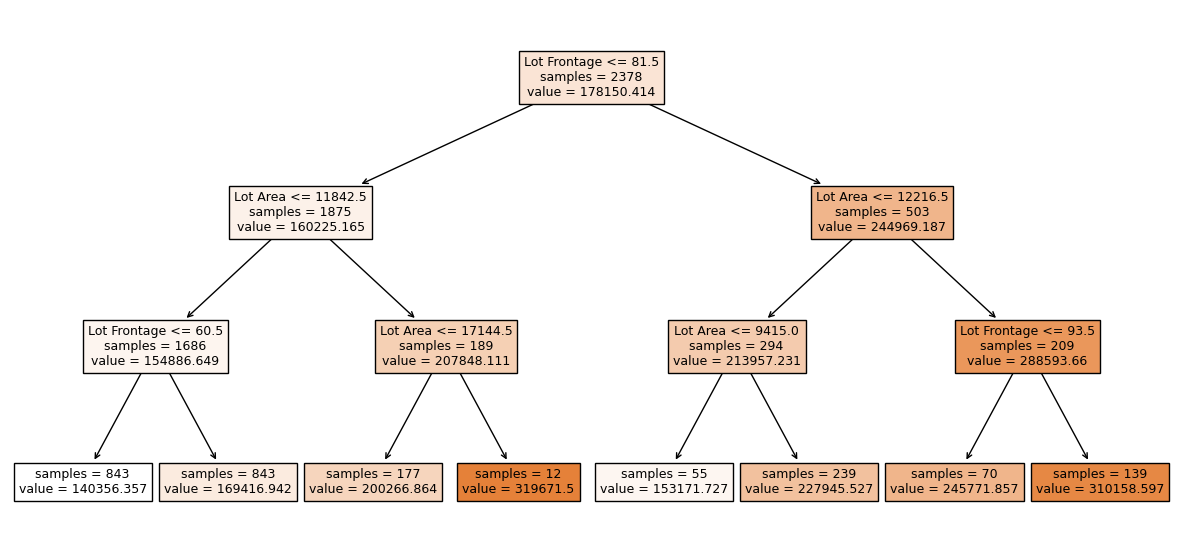

In [88]:
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_reg, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

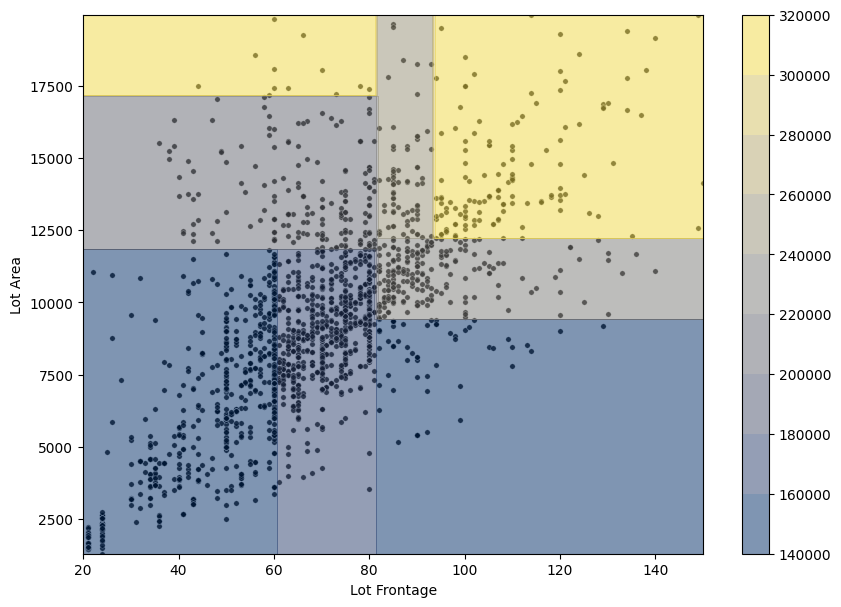

In [89]:
def plot_decision_bound_regression(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    y_pred = model.predict(X_net)
    y_pred = y_pred.reshape(xx1.shape)
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], s=15, color='black', alpha=0.8)
    contour = plt.contourf(xx1, xx2, y_pred, 10, cmap='cividis', alpha=0.5)
    fig.colorbar(contour)

# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_regression(X, y, dt_reg, fig)

---

In [90]:
# Создаём обучающую выборку    
bill_data = pd.read_csv('./data/bill_authentication.csv')
X = bill_data[['Variance', 'Skewness']]
y = bill_data['Class']

In [91]:
# Инициализируем модель дерева решений с максимальной глубиной 4 и обучаем её
dt_clf = tree.DecisionTreeClassifier(max_depth=4)
dt_clf.fit(X.values, y)

DecisionTreeClassifier(max_depth=4)

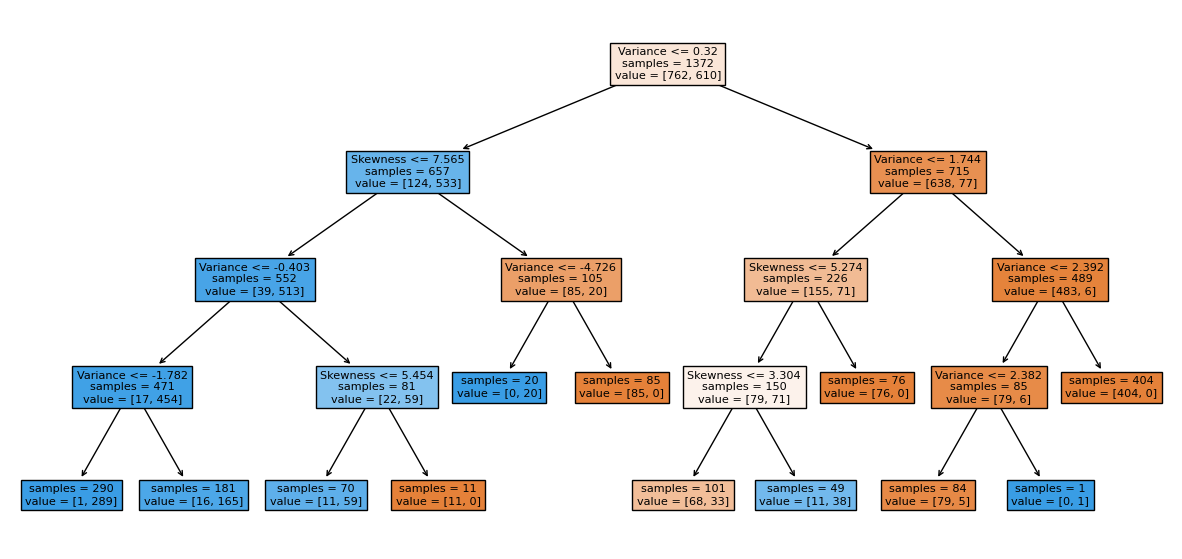

In [92]:
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_clf, #дерево решений
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

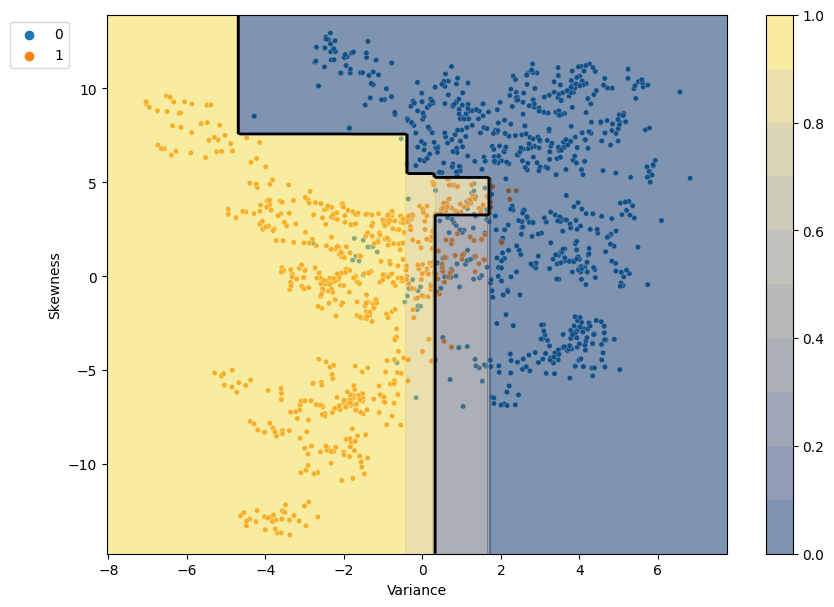

In [93]:
def plot_decision_bound_classification(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    probs = model.predict_proba(X_net)[:, 1]
    probs = probs.reshape(xx1.shape)
    
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, s=15, alpha=1)
    contour = plt.contourf(xx1, xx2, probs, 10, cmap='cividis', alpha=0.5)
    bound = plt.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    fig.colorbar(contour)
    plt.legend(bbox_to_anchor=(-0.05, 1))
# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_classification(X, y, dt_clf, fig)

---

In [94]:
ames_data = pd.read_csv('./data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)

In [95]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_rolled_mean = x.rolling(2).mean().dropna()
    y_rolling = y[x_rolled_mean.index]
    candidates = x_rolled_mean[y_rolling != 0]
    return candidates.values

In [96]:
find_candidates_for_thresholds(ames_sample['Lot Frontage'], ames_sample['SalePrice'])

array([ 53.,  58.,  61.,  65.,  69.,  71.,  76.,  86.,  94., 101.])

In [97]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_rolled = x.rolling(2).mean().dropna()
    y_rolled = y[x_rolled.index]
    candidates = x_rolled[y_rolled != 0]
    return candidates.values

In [98]:
find_candidates_for_thresholds(ames_sample['Lot Area'], ames_sample['SalePrice'])

array([ 5508. ,  7153. ,  7425. ,  7949. ,  8405.5,  8526.5,  8850. ,
        9137.5,  9466. , 10051.5, 10507. , 10834. , 11365. , 12288. ])

---

In [99]:
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred)**2).mean()

def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy


def split_params(X, y, split_param):
    j, t = split_param
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right


def calculate_weighted_impurity(X, y, split_param, criterion):
    X_left, y_left, X_right, y_right = split_params(X, y, split_param)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left/N*criterion(y_left) + N_right/N*criterion(y_right)
    return score


def find_candidates_for_thresholds(X, y):
    x = X.sort_values().drop_duplicates()
    x_roll = x.rolling(2).mean()
    y_rolling = y[x_roll.index]
    candidates = x_roll[y_rolling !=0]
    return candidates


def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params, min_weighted_impurity

In [100]:
data = pd.DataFrame({
    'x1': list(range(1, 16)),
    'y': [1, 1.2, 1.4, 1.1, 1, 5.5, 6.1, 6.7, 6.4, 6, 6, 3, 3.2, 3.1, 3]
})
X = data[['x1']]
y = data['y']

In [101]:
# Находим оптимальные параметры разбиения
optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0][0]))
print('Optimal t: {}'.format(optimal_split_params[0][1]))

Optimal j: 0
Optimal t: 5.5


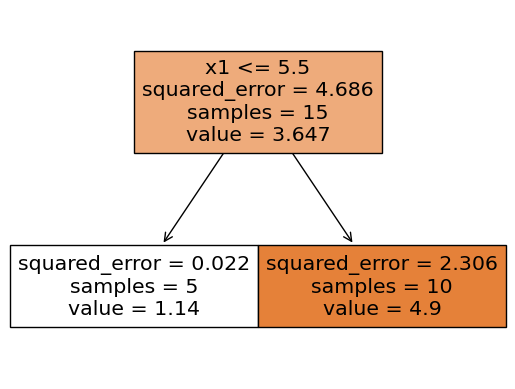

In [102]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeRegressor(
    max_depth=1, #глубина
    criterion='squared_error', #критерий информативности
    random_state=0 #генератор случайных чисел
)

dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

In [103]:
ames_data = ames_data[(ames_data["Lot Frontage"] <=150) & (ames_data["Lot Area"] <=20000)]

ames_sample = ames_data[["Lot Frontage", "Lot Area", "SalePrice"]].sample(
    n=15, random_state=42, ignore_index=True
)

X = ames_sample[["Lot Frontage", "Lot Area"]]
y = ames_sample["SalePrice"]

# Находим оптимальные параметры разбиения
optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0][0]))
print('Optimal t: {}'.format(optimal_split_params[0][1]))
print('Inpurity t: {}'.format(optimal_split_params[1]))

Optimal j: 0
Optimal t: 71.0
Inpurity t: 1414654917.0222223


---

In [104]:
bill_data = pd.read_csv('./data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

# Находим оптимальные параметры разбиения
optimal_split_params = best_split(X, y, criterion=entropy)
print('Optimal j: {}'.format(optimal_split_params[0][0]))
print('Optimal t: {}'.format(optimal_split_params[0][1]))
print('Inpurity t: {}'.format(optimal_split_params[1]))

Optimal j: 1
Optimal t: 2.2493
Inpurity t: 0.6692733344871833


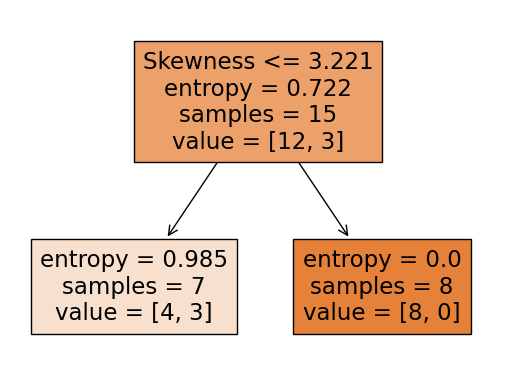

In [106]:
model = tree.DecisionTreeClassifier(
    max_depth=1,
    criterion='entropy',
    random_state=0
)
model.fit(X,y)
tree.plot_tree(
    decision_tree=model, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

Optimal j: 1
Optimal t: 2.249
Impurity: 0.669


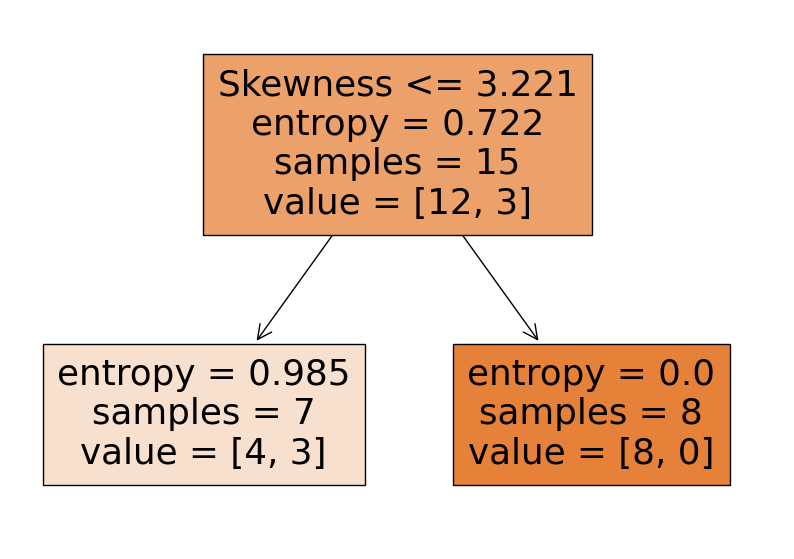

In [109]:
# Находим оптимальные параметры разбиения
optimal_params = best_split(X, y, criterion=entropy)
print('Optimal j: {}'.format(optimal_params[0][0]))
print('Optimal t: {:.3f}'.format(optimal_params[0][1]))
print('Impurity: {:.3f}'.format((optimal_split_params[1])))

# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize = (10, 7))
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);